In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib

Using matplotlib backend: TkAgg


In [18]:
# 加载训练集和测试集的数据
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [20]:
train.drop(train[(train.GrLivArea>4000)&(train.SalePrice<300000)].index, inplace=True)

In [21]:
train.drop(train[(train.TotalBsmtSF>3000)&(train.SalePrice<300000)].index, inplace=True)

In [22]:
# 拼接训练集和测试集数据，并删除Id,SalePrice
full = pd.concat([train,test],ignore_index=True)
full.drop(['Id','SalePrice'],axis=1,inplace=True)

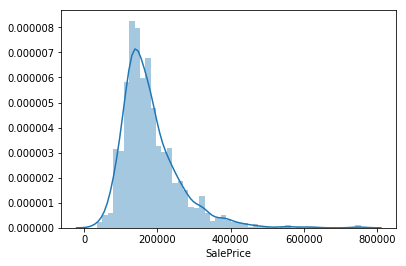

In [23]:
# 首先查看SalePrice的柱状图，可以看到SalePrice不是一个正态分布，需要把标签变成正态分布

sns.distplot(train['SalePrice'])

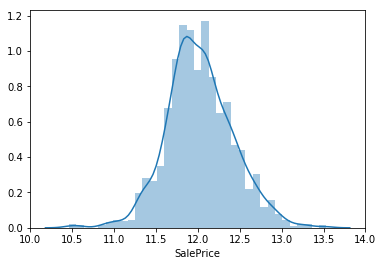

In [24]:
sns.distplot(np.log(train['SalePrice']))

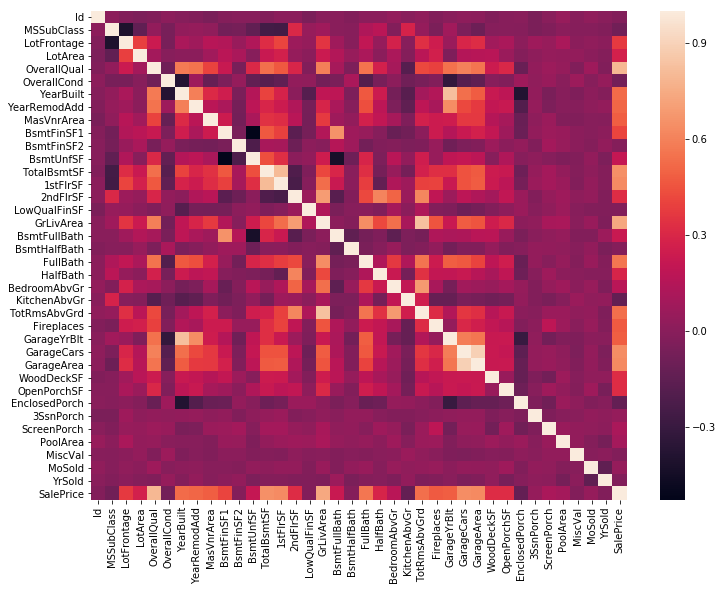

In [25]:
# 画出所有数字特征与变量的相关性系数热度图，可以看到OverallQual, GrLivArea,TotalBsmtSF,YearBuild和价格有较大的相关性
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train.corr())

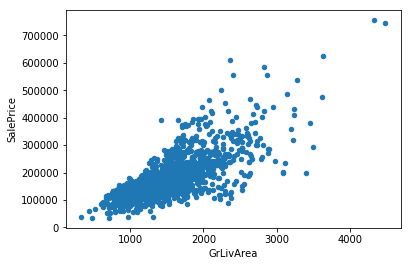

In [26]:
# 可以看到GrLivArea和TotalBsmtSF基本成线性关系
var = 'GrLivArea'
data = pd.concat([train[var],train['SalePrice']],axis=1)
data.plot.scatter(x=var,y='SalePrice')

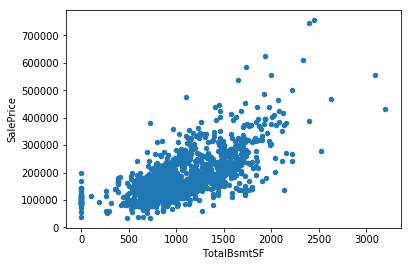

In [27]:
var = 'TotalBsmtSF'
data = pd.concat([train[var],train['SalePrice']],axis=1)
data.plot.scatter(x=var,y='SalePrice')

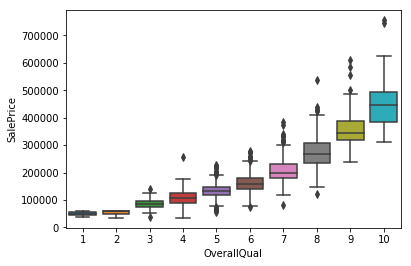

In [28]:
# OverallQual值越高，房价越高
var = 'OverallQual'
data = pd.concat([train['SalePrice'],train[var]],axis=1)
sns.boxplot(x=var,y='SalePrice',data=data)

In [29]:
corrmat = train.corr()

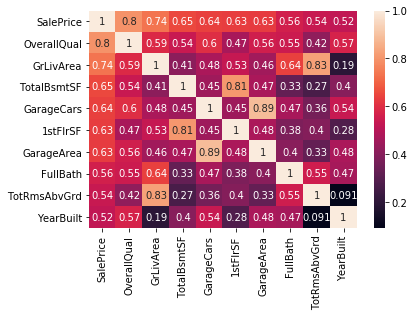

In [30]:
k = 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.heatmap(cm,annot=True,xticklabels=cols.values, yticklabels=cols.values)

In [31]:
corrmat['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.795524
GrLivArea        0.735199
TotalBsmtSF      0.652972
GarageCars       0.640546
1stFlrSF         0.631116
GarageArea       0.628667
FullBath         0.561904
TotRmsAbvGrd     0.537827
YearBuilt        0.523172
YearRemodAdd     0.507333
GarageYrBlt      0.486705
MasVnrArea       0.482226
Fireplaces       0.469653
BsmtFinSF1       0.408562
LotFrontage      0.370210
WoodDeckSF       0.325677
OpenPorchSF      0.322014
2ndFlrSF         0.321494
HalfBath         0.285488
LotArea          0.268317
BsmtFullBath     0.227696
BsmtUnfSF        0.212898
BedroomAbvGr     0.168197
ScreenPorch      0.111723
PoolArea         0.099604
MoSold           0.044966
3SsnPorch        0.044698
BsmtFinSF2      -0.013849
BsmtHalfBath    -0.016676
Id              -0.020852
MiscVal         -0.021137
LowQualFinSF    -0.025533
YrSold          -0.029700
OverallCond     -0.077540
MSSubClass      -0.083570
EnclosedPorch   -0.128405
KitchenAbvGr    -0.135838
Name: SalePr

In [32]:
full['LotFrontage'] = np.sqrt(full['LotArea'])
train['LotFrontage'] = np.sqrt(full['LotArea'])

In [34]:
# 查看缺失值
# PoolQC, MiscFeature,Alley,Fence,FireplaceQU缺失率大于50%，去掉
#Garage系列,缺失的情况类似，估计是同一种手段采集的数据，另外关于Garage的信息已经由，GarageCar表达，所以这些可以删去
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1451,0.995882
MiscFeature,1403,0.962938
Alley,1366,0.937543
Fence,1176,0.807138
FireplaceQu,690,0.473576
GarageCond,81,0.055594
GarageType,81,0.055594
GarageYrBlt,81,0.055594
GarageFinish,81,0.055594
GarageQual,81,0.055594


In [35]:
# 删除上面的列
full = full.drop((missing_data[missing_data['Total']>1]).index,1)

In [36]:
tmp = full.isnull().sum()
tmp[tmp>0]

BsmtFinSF1      1
BsmtFinSF2      1
BsmtFullBath    2
BsmtHalfBath    2
BsmtUnfSF       1
Electrical      1
Exterior1st     1
Exterior2nd     1
Functional      2
GarageArea      1
GarageCars      1
KitchenQual     1
MSZoning        4
SaleType        1
TotalBsmtSF     1
Utilities       2
dtype: int64

In [37]:
for col in tmp[tmp>0].index:
    if full[col].dtype == np.object:
        full[col].fillna('None',inplace=True)
    else:
        full[col].fillna(0,inplace=True)

In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
full['YearBuilt'] = LabelEncoder().fit_transform(full.YearBuilt)

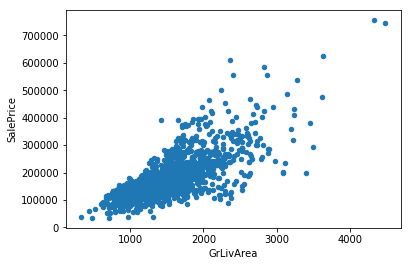

In [40]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice');

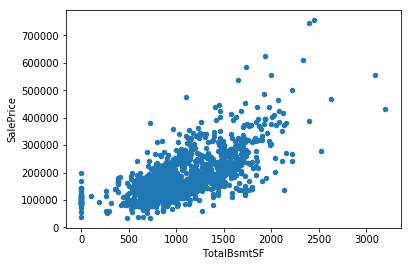

In [41]:
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice');

In [42]:
full.shape

(2916, 62)

In [43]:
full = pd.get_dummies(full)

In [44]:
full.shape

(2916, 228)

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
full = StandardScaler().fit_transform(full)

In [47]:
train_len = len(train)
train_x = full[:train_len]
test_x = full[train_len:]
y = train.SalePrice

In [29]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
model.fit(train_x,y)

In [ ]:
result_pred = model.predict(test_x)

In [ ]:
result = pd.DataFrame({'Id':test.Id,'SalePrice':result_pred})
result.to_csv('submission1.csv',index=False)

In [48]:
import xgboost as xgb
xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.4,learning_rate=0.01,max_depth=8,alpha=10,n_estimators=600,subsample=0.7)

In [49]:
xg_reg.fit(train_x,y)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

In [50]:
pred=xg_reg.predict(test_x)  
result2=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result2.to_csv("submission1.csv",index=False)